# Práctico 7 Procesamiento de Imágenes: Procesamiento Morfológico


***

## Profesores:  
- Claudio Delrieux  

- Steven Martinez Vargas


## Alumno:  
- Leandro Bognino	36887290  



___

## Consigna:  

Desarrollar un aplicativo que permita abrir una imagen y automáticamente convertirla a niveles de grises (en caso de no estarlo) y visualizarla. Con esta imagen se aplicarán los siguientes filtros morfológicos, los cuales deben poderse seleccionar de una lista:
- Erosión (tomar el mínimo valor de luminancia de la vecindad).
- Dilatación (máximo)
- Apertura
-Cierre
- Borde morfológico (frontera interna y externa)
- Mediana
- Top-hat  
El elemento estructurante será de una ventana de 3x3 pixeles.  
El aplicativo debe incluir una función de copiado de la imagen procesada, de tal manera que esta pueda tomarse como imagen de entrada para así poder aplicar dos o más filtros en secuencia.  
El resultado del filtro debe poder guardarse como una nueva imagen en nivel de grises.  
Adicionalmente se debe mostrar un plot con el resultado respectivo para cada uno de los filtros indicados.  
Nota: La función que desarrollaron para la convolución es la misma que pueden usar para recorrer toda la imagen y aplicar el filtro morfológico.   

### Dependencias e inclusión de librerías

In [1]:
import numpy as np
import imageio as io
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from skimage.transform import resize

### 0. Funciones de soporte desarrolladas en los trabajos previos

In [2]:
# Descargar, leer, normalizar la imagen.
def get_and_read_img (url, name=''):
  img = io.imread(url)
  img = np.clip(img/255.,0.,1.)
  #img = resize(img,(600,600))
  return img

# Mostrar Imagen
def show_img (img, size = (8,8)):
  plt.figure(figsize = size)
  plt.imshow(img)
  plt.show()

def show2_img (img1, img2, title, size = (30,30)):
  f, axarr = plt.subplots(1,2,figsize=size)
  axarr[0].set_title("Original")
  axarr[0].imshow(img1)
  axarr[1].set_title(title)
  axarr[1].imshow(img2)
  plt.show()

# RGB a YIQ
def rgb2yiq (img):
  RGB_2_YIQ_MATRIX = np.array([[ 0.299, 0.587, 0.114], 
                               [ 0.595716, -0.274453, -0.321263], 
                               [ 0.211456, -0.522591, 0.311135]])
  
  im_yiq =  np.copy(img)
  for i in range(len(img)):
    for j in range(len(img[0])):
        im_yiq[i][j] = RGB_2_YIQ_MATRIX.dot(img[i][j])

  im_yiq[:,:,0] = np.clip(im_yiq[:,:,0],0,1)
  im_yiq[:,:,1] = np.clip(im_yiq[:,:,1],-0.5957, 0.5957)
  im_yiq[:,:,2] = np.clip(im_yiq[:,:,2],-0.5226, 0.5226)

  return im_yiq

# YIQ a RGB
def yiq2rgb (img):
  YIQ_2_RGB_MATRIX = np.array([[1, 0.9663, 0.6210], 
                              [1, -0.2721, -0.6474], 
                              [1, -1.1070, 1.7046]])
  im_rgb =  np.copy(img)
  for i in range(len(img)):
    for j in range(len(img[0])):
        im_rgb[i][j] = np.clip(YIQ_2_RGB_MATRIX.dot(img[i][j]),0,1)

  return im_rgb

In [3]:
def filter_image(image, kernel):
    imagen_filtrada = np.copy(image)
    imagen_con_borde = np.pad(np.copy(image), pad_width=int(len(kernel)/2), mode='reflect')

    for i in range(len(image)):
        for j in range(len(image[0])):
            block = imagen_con_borde[i:i+len(kernel), j:j+len(kernel)]
            block = block* kernel
            block = block.sum() 
            if (kernel.sum() != 0):
                block = block / kernel.sum()
            if (block > 1):
                block = 1.
            if block < 0:
                block = 0.
            imagen_filtrada[i][j] = block

    return imagen_filtrada

### 0.1 Funciones de Procesamiento Morfológico

In [31]:
def filter_image(image, kernel = 0, modo = 'default', n_struct_element = 3):
    imagen_filtrada = np.copy(image)
    if (kernel == 0):
      imagen_con_borde = np.pad(np.copy(image), pad_width=int(n_struct_element/2), mode='reflect')
    else:
      imagen_con_borde = np.pad(np.copy(image), pad_width=int(len(kernel)/2), mode='reflect')

    for i in range(len(image)):
        for j in range(len(image[0])):
          if (kernel == 0):
            block = imagen_con_borde[i:i+n_struct_element, j:j+n_struct_element]
          else:
            block = imagen_con_borde[i:i+len(kernel), j:j+len(kernel)]
          if (modo == 'default'):
            block = block* kernel
            block = block.sum() 
            if (kernel.sum() != 0):
                block = block / kernel.sum()
            if (block > 1):
                block = 1.
            if block < 0:
                block = 0.
          elif (modo == 'erosion'):
            block = np.amin(block)
          elif (modo == 'dilatacion'):
            block = np.amax(block)
          elif (modo == 'mediana'):
            block = np.median(block)

          imagen_filtrada[i][j] = block

    return imagen_filtrada

In [88]:
def apertura(imagen, n_struct_element):
  tmp_imagen = filter_image(imagen, kernel = 0, modo='erosion', n_struct_element=n_struct_element)
  imagen_salida = filter_image(tmp_imagen , kernel = 0, modo='dilatacion', n_struct_element=n_struct_element)
  imagen_salida = np.clip(imagen_salida,0,1.)
  return imagen_salida

def cierre(imagen, n_struct_element):
  tmp_imagen =  filter_image(imagen , kernel = 0, modo='dilatacion', n_struct_element=n_struct_element)
  imagen_salida = filter_image(tmp_imagen, kernel = 0, modo='erosion', n_struct_element=n_struct_element)
  imagen_salida = np.clip(imagen_salida,0,1.)
  return imagen_salida

def frontera_ext(imagen, n_struct_element):
  tmp_imagen = filter_image(imagen , kernel = 0, modo='dilatacion', n_struct_element=n_struct_element)
  imagen_salida = tmp_imagen - imagen
  imagen_salida = np.clip(imagen_salida,0,1.)
  return imagen_salida

def frontera_int(imagen, n_struct_element):
  tmp_imagen = filter_image(imagen , kernel = 0, modo='erosion', n_struct_element=n_struct_element)
  imagen_salida = imagen - tmp_imagen
  imagen_salida = np.clip(imagen_salida,0,1.)
  return imagen_salida

def gradiente(imagen, n_struct_element):
  tmp_imagen2 = filter_image(imagen , kernel = 0, modo='erosion', n_struct_element=n_struct_element)
  tmp_imagen1 = filter_image(imagen , kernel = 0, modo='dilatacion', n_struct_element=n_struct_element)
  imagen_salida = tmp_imagen1 - tmp_imagen2
  imagen_salida = np.clip(imagen_salida,0,1.)
  return imagen_salida

def top_hat(imagen, n_struct_element):
  tmp_imagen = apertura(imagen,n_struct_element=n_struct_element)
  imagen_salida = imagen - tmp_imagen 
  imagen_salida = np.clip(imagen_salida,0,1.)
  return imagen_salida

In [89]:
def wrapper_filters (imagen, n_struct_element, modo = 'erosion'):
  if ( (modo == 'erosion') or (modo == 'dilatacion') or (modo == 'mediana')):
    return filter_image(imagen,modo=modo, n_struct_element=n_struct_element)
  elif(modo == 'apertura'):
    return apertura(imagen, n_struct_element)
  elif(modo == 'cierre'):
    return cierre(imagen, n_struct_element)
  elif(modo == 'frontera_ext'):
    return frontera_ext(imagen, n_struct_element)
  elif(modo == 'frontera_int'):
    return frontera_int(imagen, n_struct_element)
  elif(modo == 'gradiente'):
    return gradiente(imagen, n_struct_element)
  elif(modo == 'top_hat'):
    return top_hat(imagen, n_struct_element)


### 0.2 Visualización de los datos

In [90]:
def plot_fft(image,mag,phase):
  plt.set_cmap('gray')
  fig, ax = plt.subplots(1, 3, figsize=(30, 50))
  ax[0].imshow(image)
  ax[0].set_title('Imagen')
  ax[1].imshow(mag)
  ax[1].set_title('Magnitud')
  ax[2].imshow(phase)
  ax[2].set_title('Fase')
  plt.show()  

### 1. Carga de la imagen a procesar

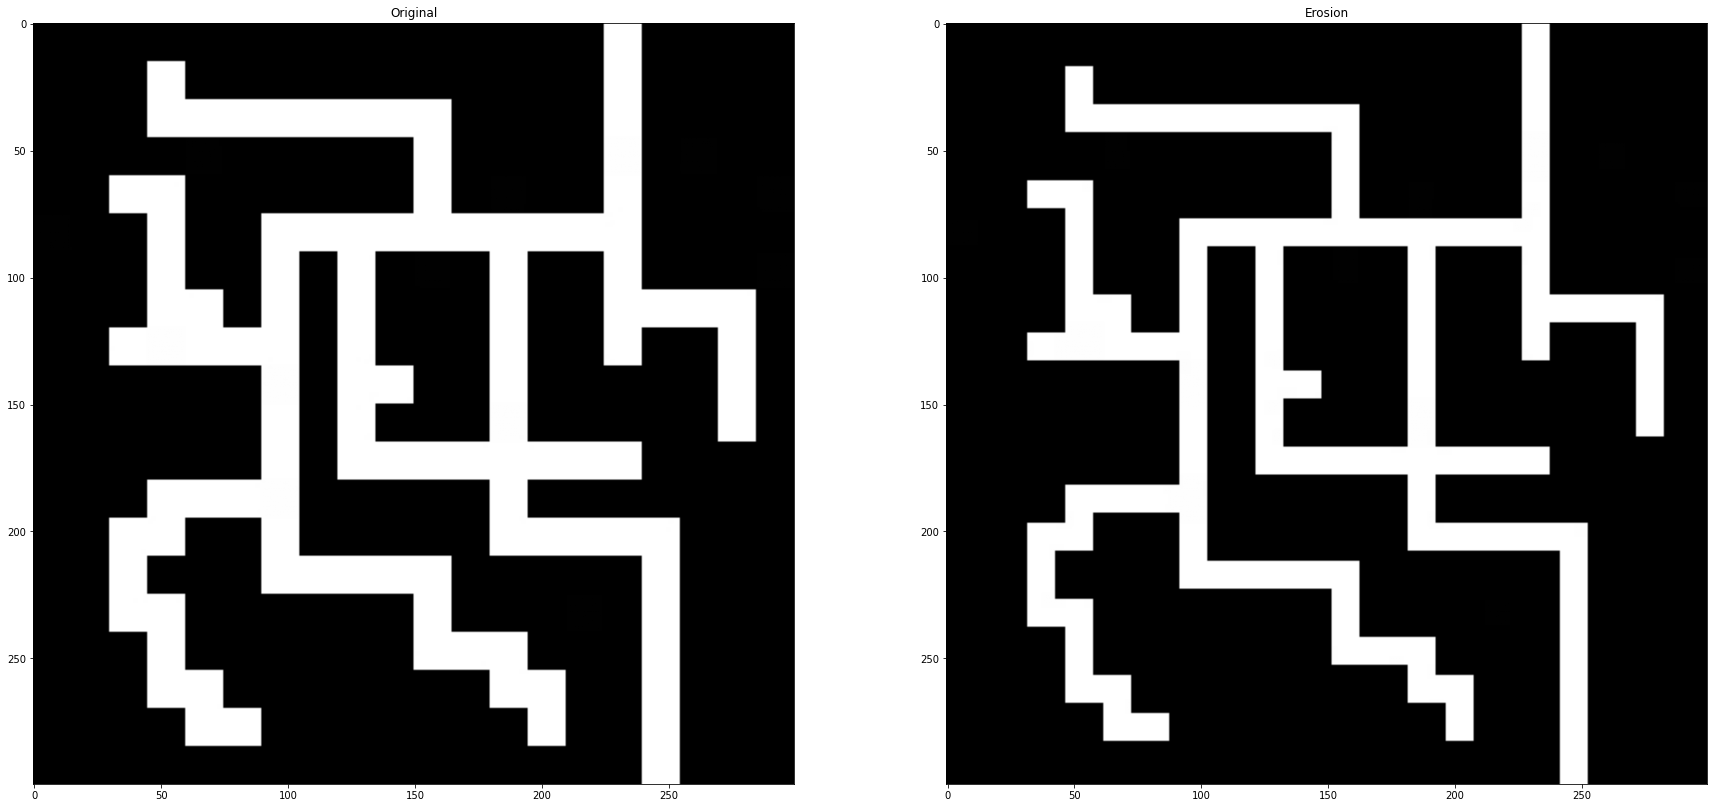

In [99]:
#@title Imágenes de Entrada: { run: "auto" }
dict_urls = {'Laberinto':'https://thumbs.dreamstime.com/b/round-labyrinth-isolated-white-background-vector-illustratio-illustration-87870515.jpg',
             'Laberinto2': 'https://raw.githubusercontent.com/exciteabletom/mazesolver/master/pics/upscaled_maze.jpg',
             'Huella':'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRgUYJGgRqpKF7bhlyGVRk61OM38w6NAcSfTA9nC6mBnRuqO8F_dEyf68ycsHr7wGqrm6I&usqp=CAU'
            }

Imagen1 = 'Laberinto2' #@param ["Huella","Laberinto","Laberinto2"]
im = get_and_read_img(dict_urls[Imagen1])

image_filter = filter_image(im,modo='erosion',n_struct_element=5)

show2_img(im,image_filter,'Erosion')



### 3. Filtros Morfológicos Seleccionables

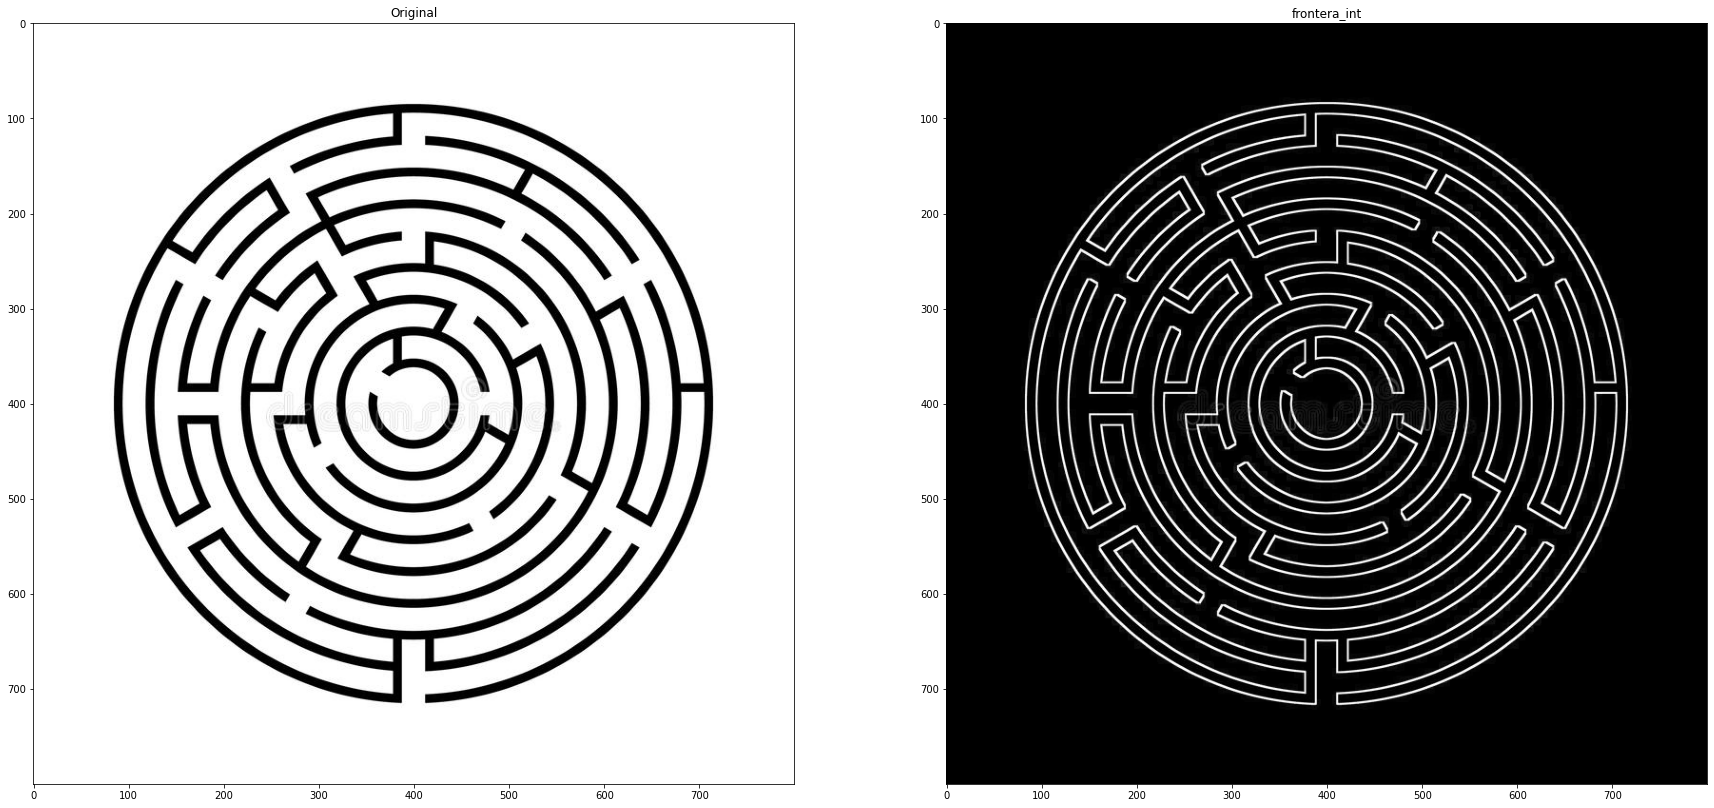

In [106]:
#@title Filtro Procesamiento Morfológico: { run: "auto" }

Imagen1 = 'Laberinto' #@param ["Huella","Laberinto","Laberinto2"]
im = get_and_read_img(dict_urls[Imagen1])
Filtro = 'frontera_int' #@param ["erosion","dilatacion","mediana","cierre","apertura","frontera_ext","frontera_int","gradiente","top_hat"]
Tamaño_Elemento_Estructurante = '5' #@param ["3","5","7","11","15"]

image_filter = wrapper_filters(im,modo=Filtro,n_struct_element=int(Tamaño_Elemento_Estructurante))

show2_img(im,image_filter,Filtro)

path='./image_filter.png'
io.imsave(path,image_filter)

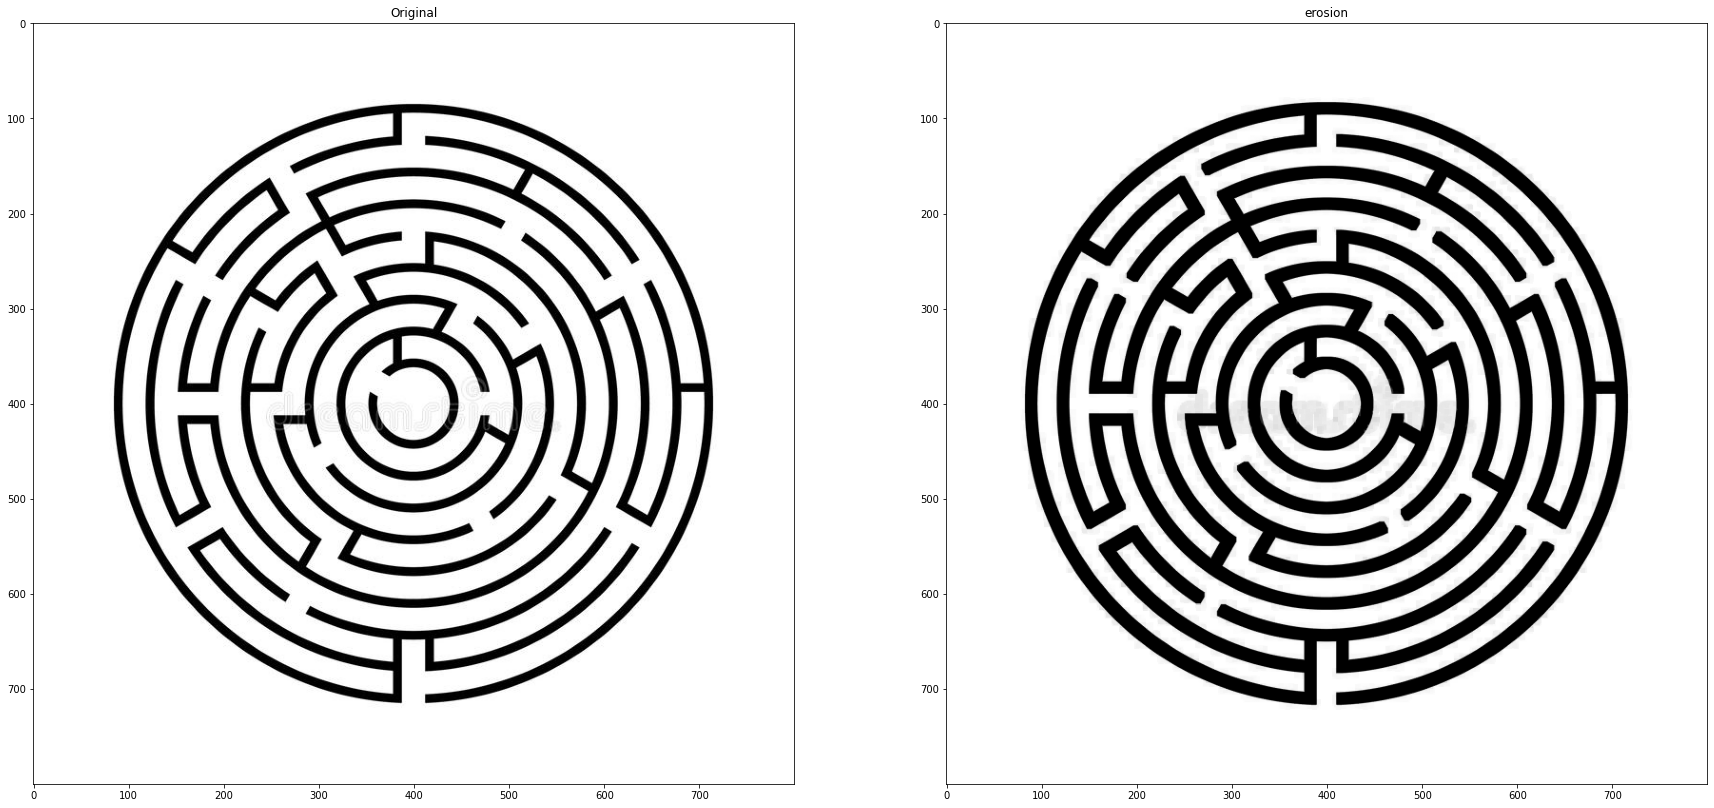

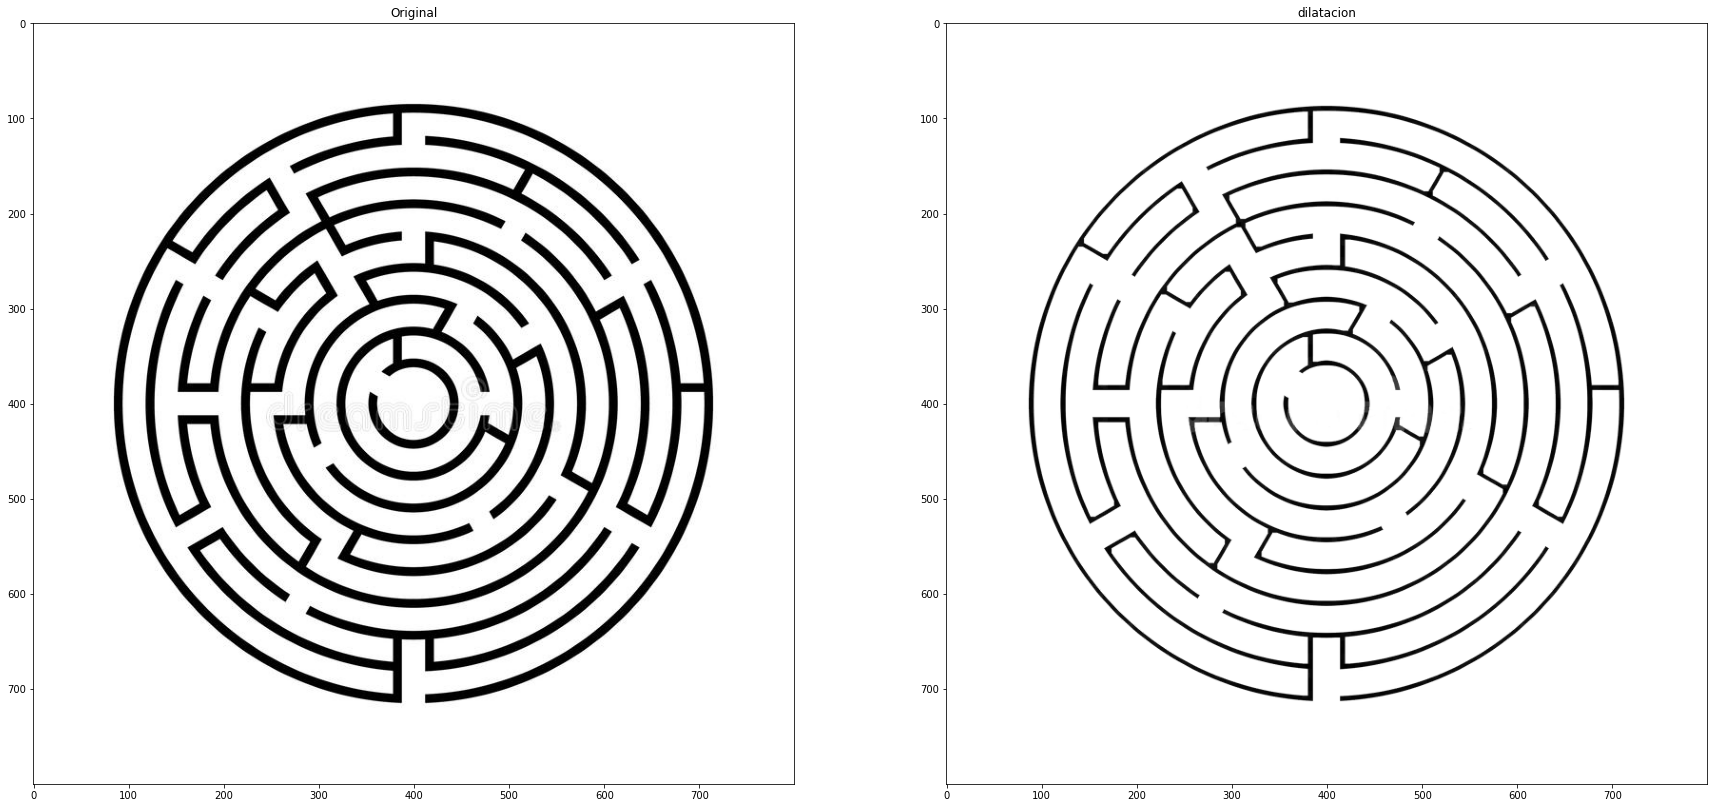

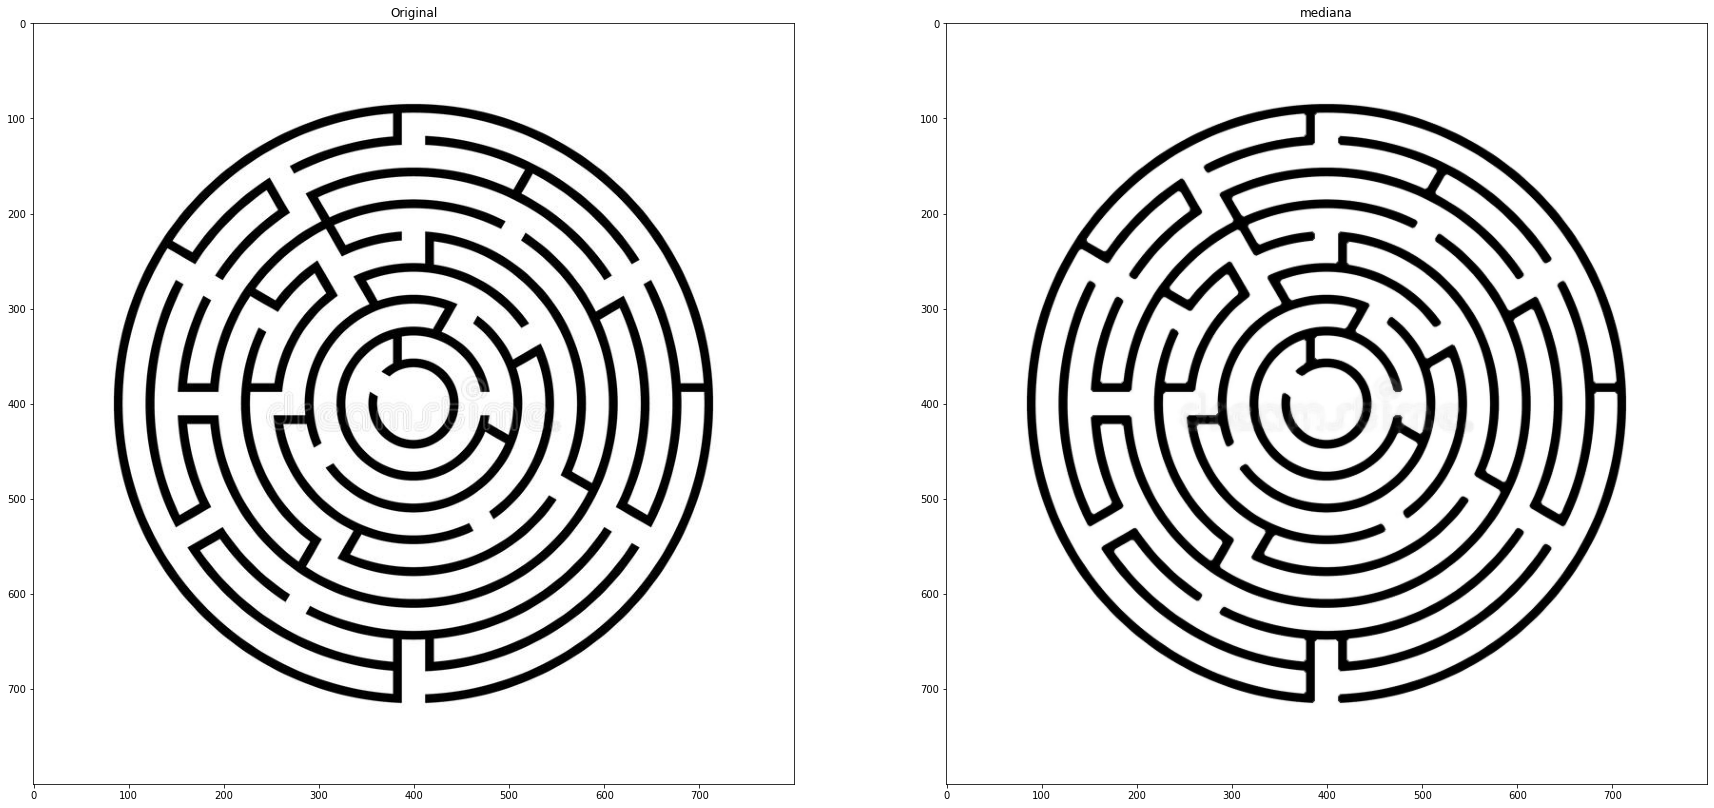

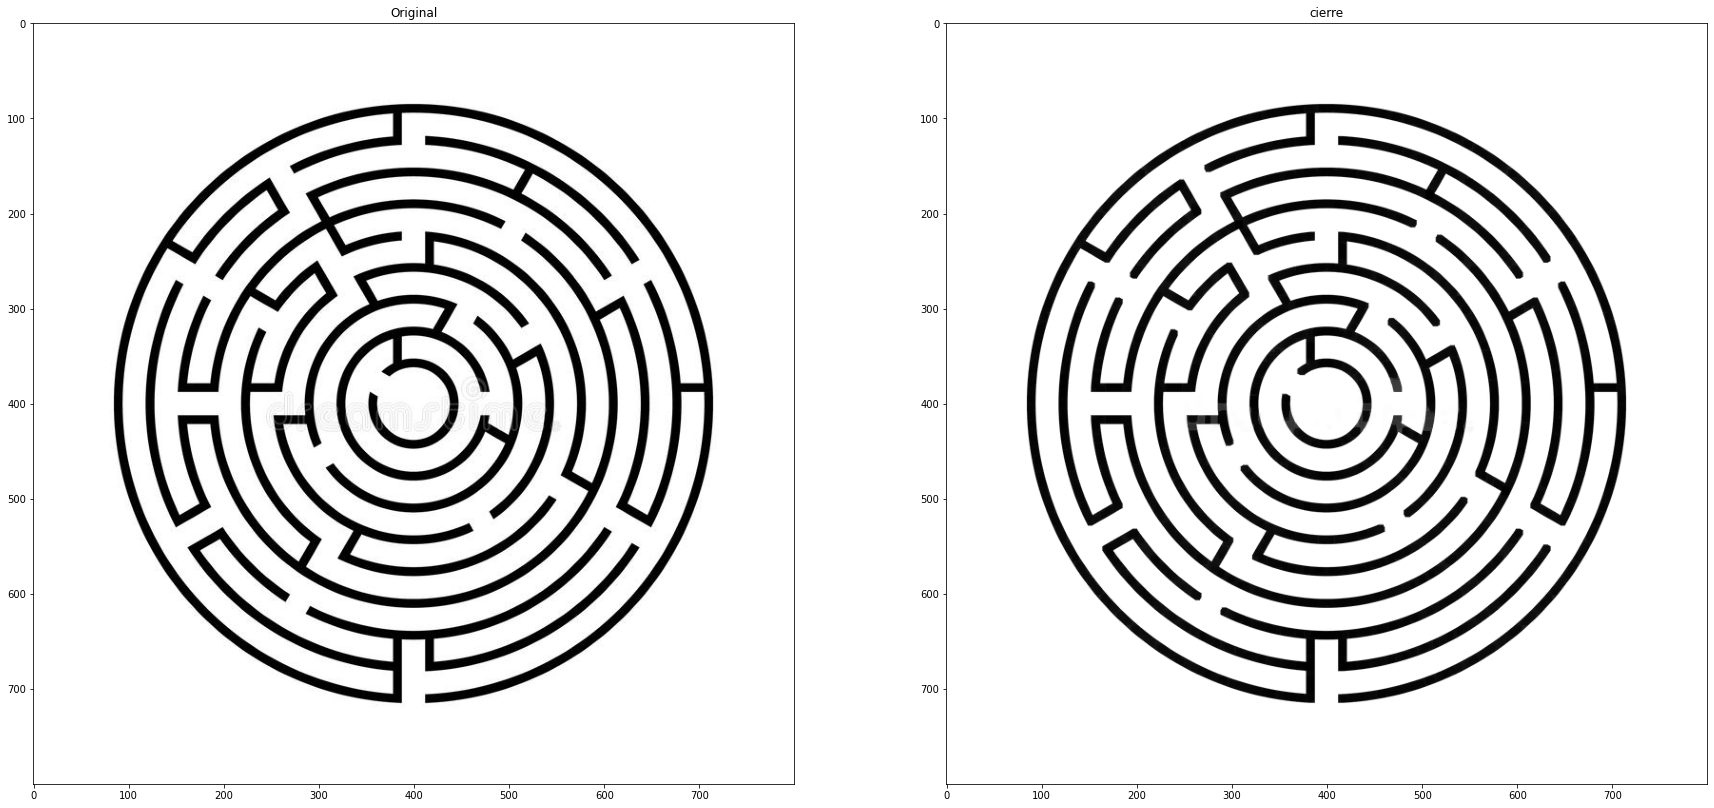

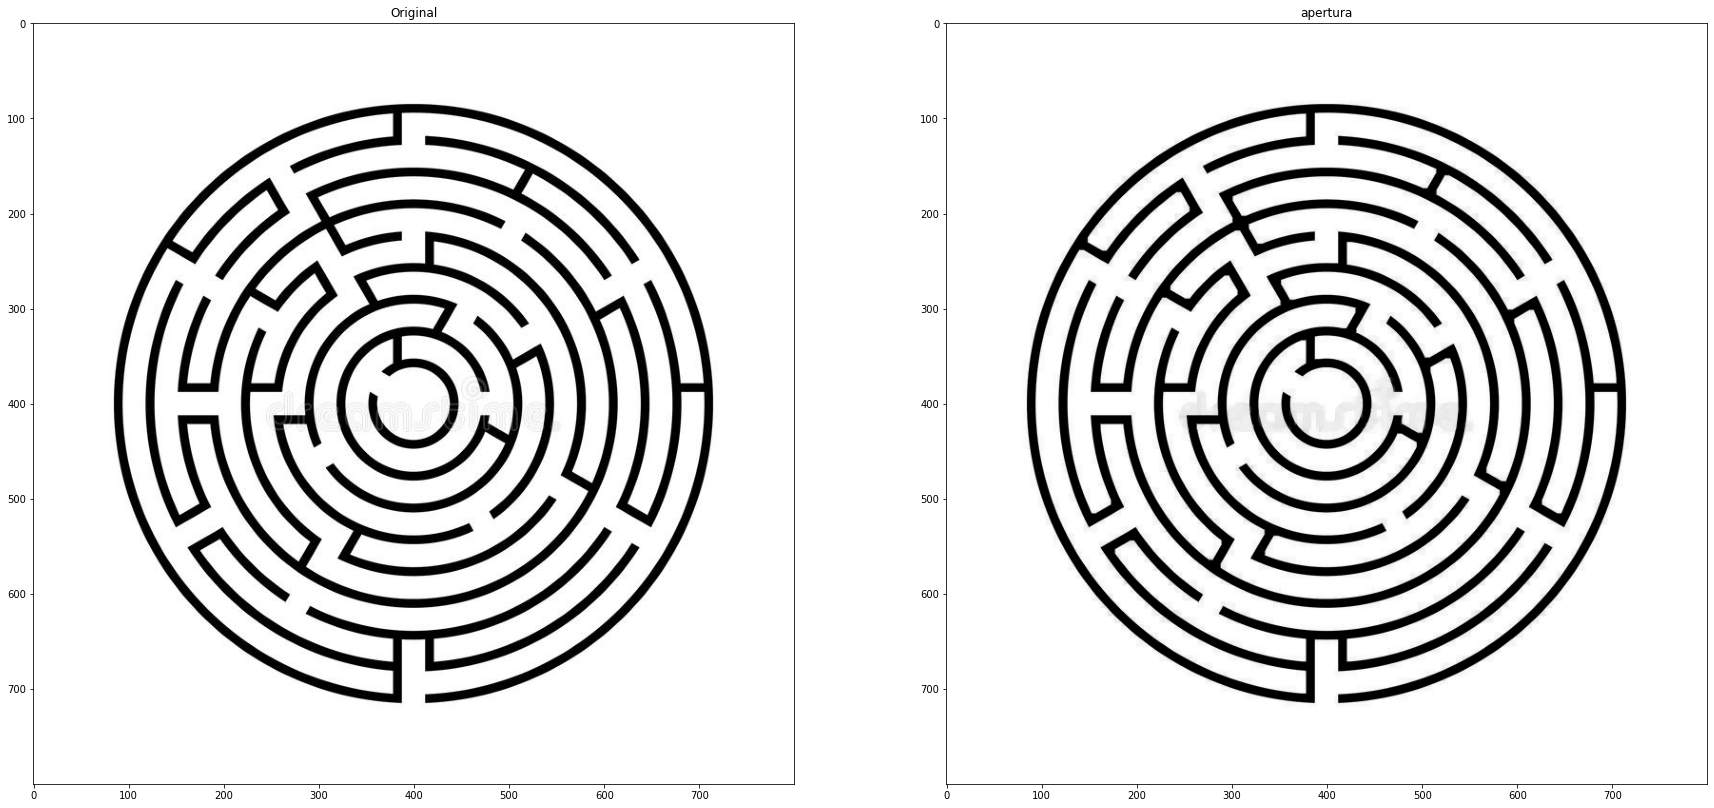

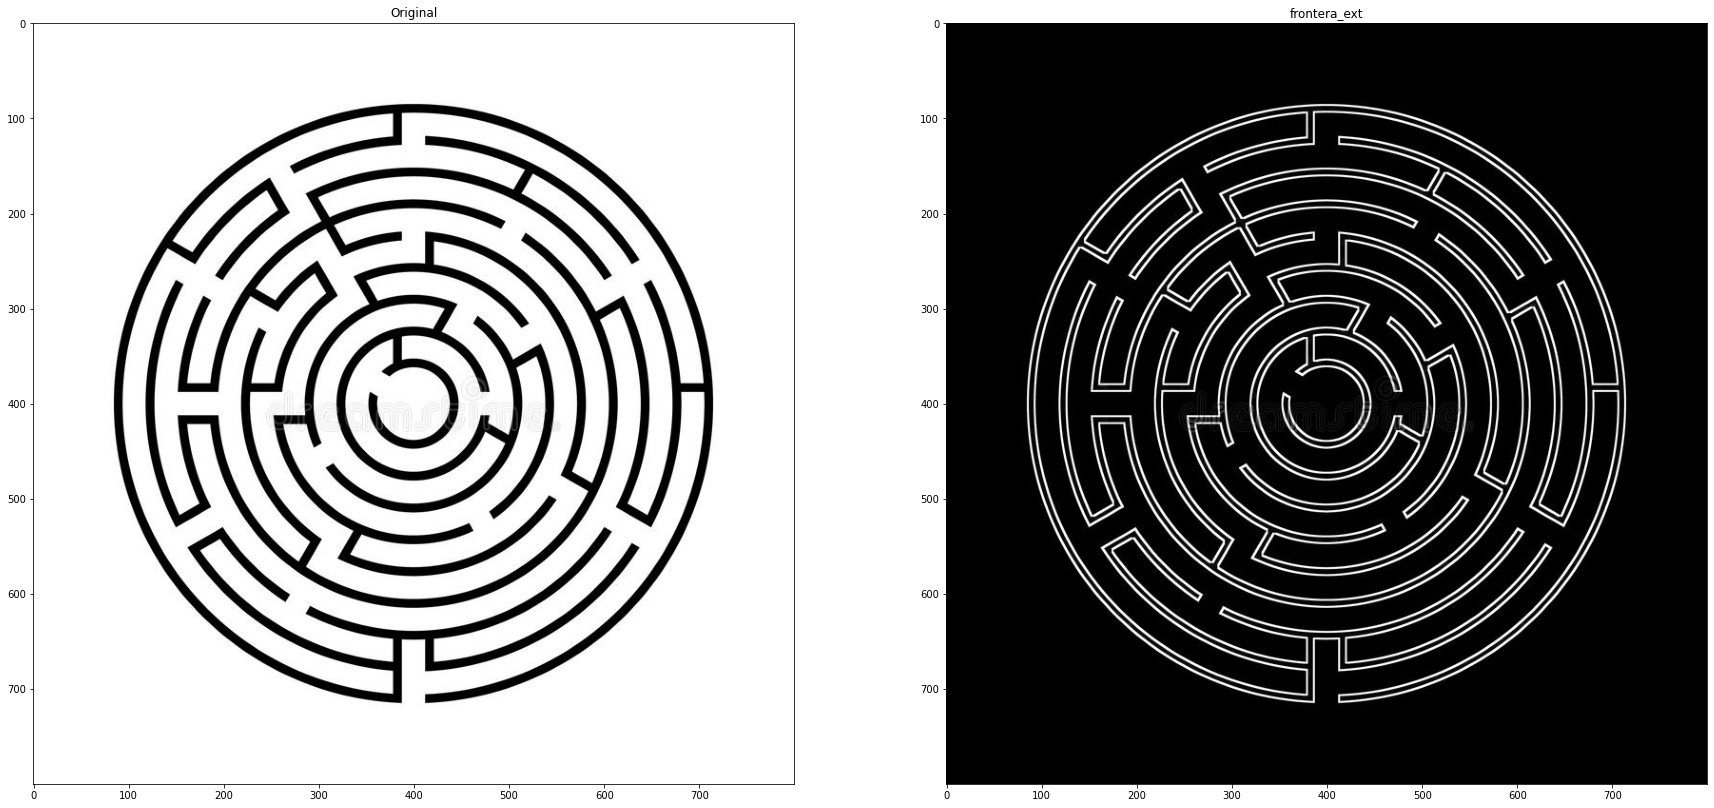

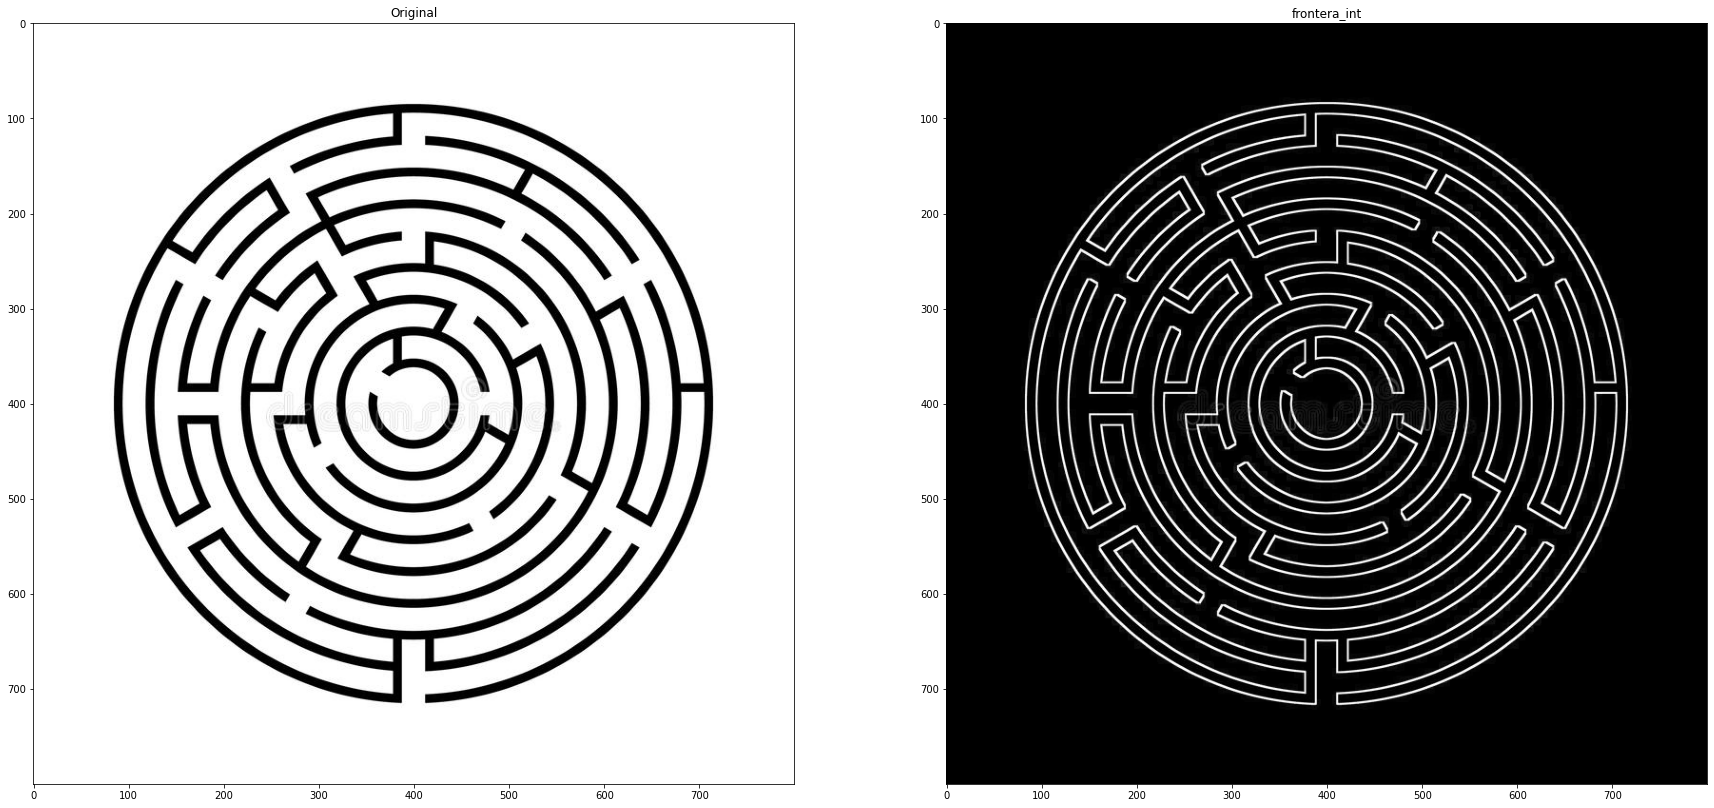

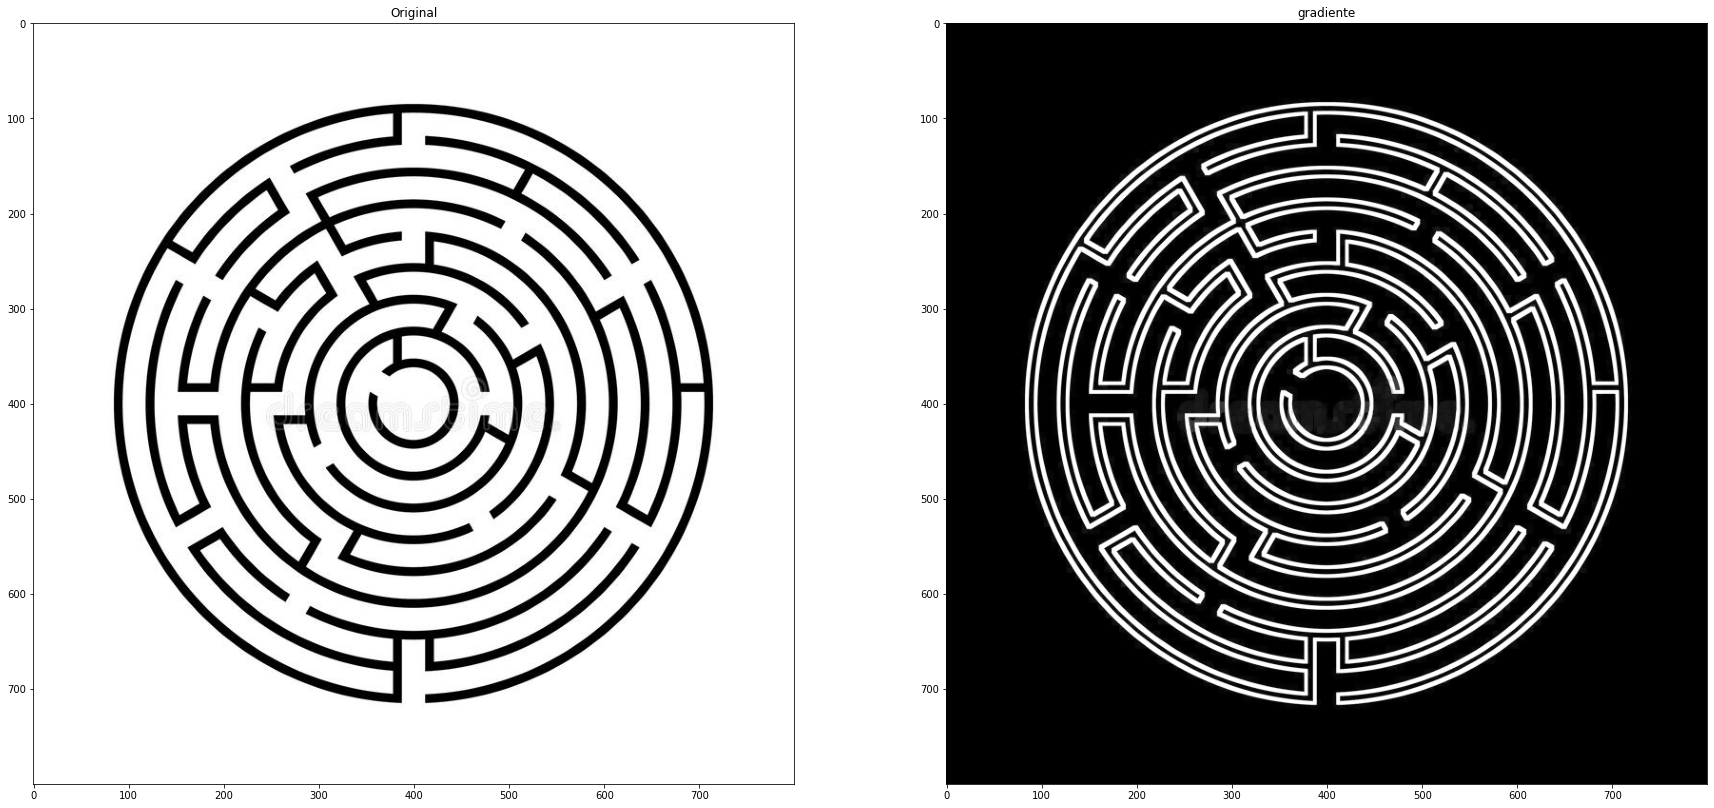

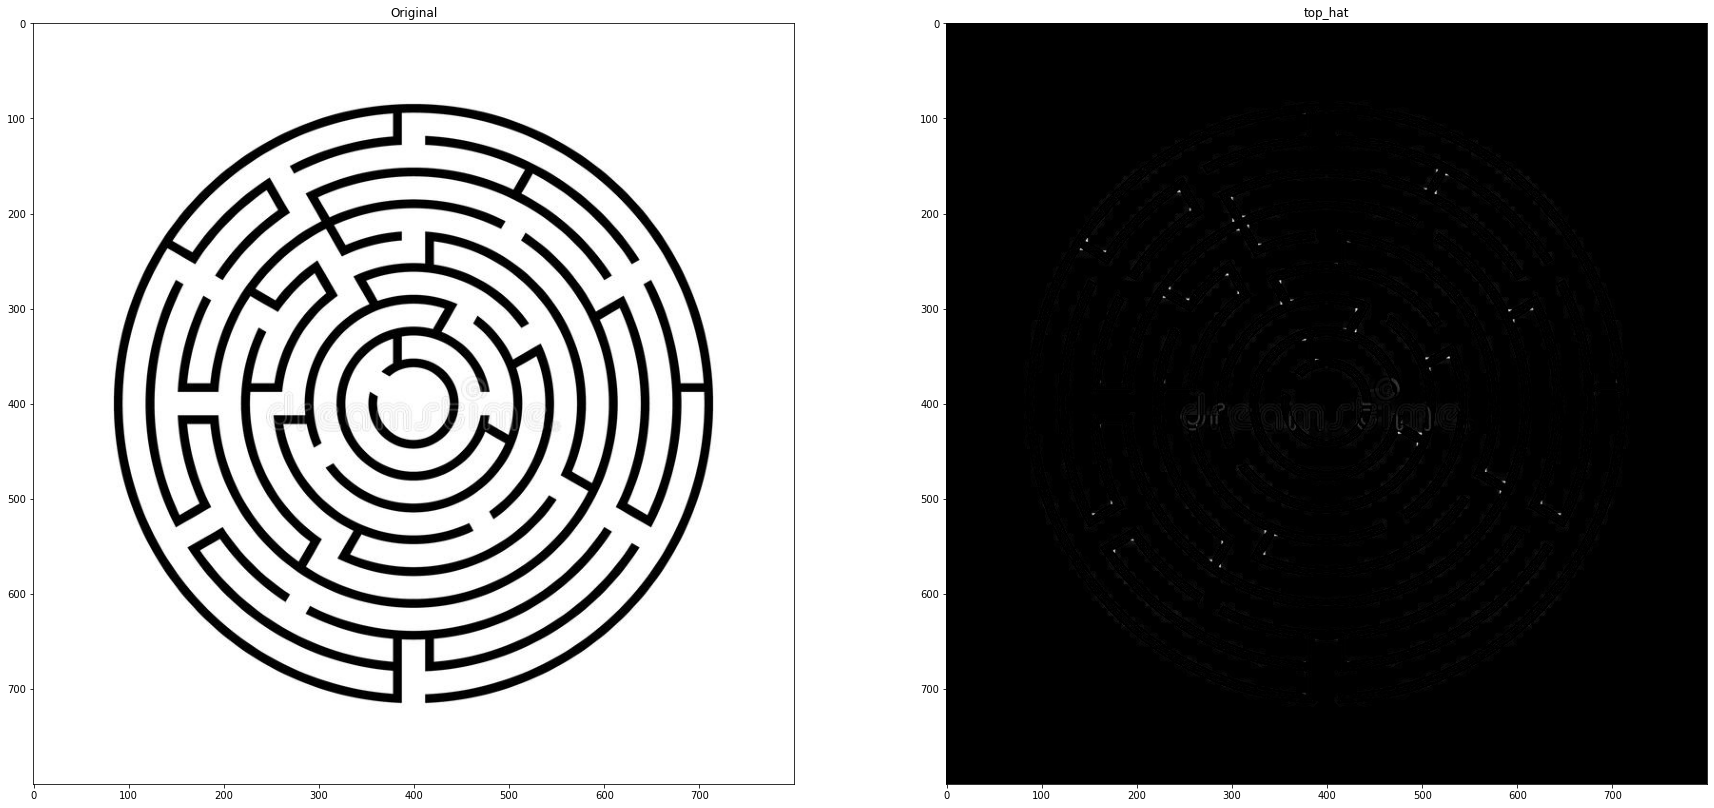

In [107]:
filters = ["erosion","dilatacion","mediana","cierre","apertura","frontera_ext","frontera_int","gradiente","top_hat"]
for i in filters:
  image_rgb = wrapper_filters(im,n_struct_element=5, modo=i)
  show2_img(im,image_rgb,i)

## Conclusiones

Las operaciones morfológicas permiten cambiar la forma de la imagen, particularmente, en la utilización de un laberinto, las operaciones de erosión y dilatación, reducen el espacio por el cual pasar y aumentan el mismo respectivamente. La mediana "redondea" las esquinas abruptas, ya que sería como un filtro pasa bajos.  

En el caso de la frontera interior y exterior se nota la diferencia sutilmente teniendo en cuenta el espacio donde se puede pasar en el laberinto. A diferencia de la erosion y dilatación resalta las fronteras. El gradiente produce un efecto similar en esta imagen a los dos anteriores, pero resalta aún más los bordes.  

La operación de top hat produce un efecto interesante, nos permite ver unas palabras propias en el fondo de la imagen que difícilmente era verla en las imágenes anteriores y la original.  

En conclusión, las operaciones morfológicas nos permiten cambiar la forma de la imagen según la aplicación necesaria. En el ejemplo, nos permite modificar el laberinto y hasta "descubrir" una palabra oculta a simple vista. Otra aplicación podría ser, al tener un mapa, usar el elemento esctructurante del tamaño de nuestro vehículo y dilatar los obstáculos para estar seguros que nuestro vehículo puede pasar seguro por los espacios libres.
